In [470]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from fuzzywuzzy import fuzz
from fuzzywuzzy import process

% matplotlib inline

# Allie Surina
## Capstone Project: Predicting Injuries from MLB Game & Disabled List Data

## Project Goal: To find and analyze game log data for MLB games from 2000 - 2016, along with whether a player was placed on the Disabled List after a particular game (i.e. he was injured during his previous game), and predict:
- ## (a) whether an injury will happen in a game.
- ## (b) whether a player will be injured in the next game.

## Data:
* **GAMELOG Data** From Retrosheets, imported in `baseball-game-logs-file-imports.ipynb` Jupyter Notebook for data dictionary.

* **INJURY Data** (See `injury_data_scrape.ipynb` Jupyter Notebook)


## Methods:
* I plan to use machine learning and classification to predict whether an injury will happen in a game, and to predict whether a player will be injured in the next game. 
* I will analyze two dataframes:
 * The first dataframe will contain game data with each row referencing a different game over time.
 * The second dataframe and analysis will be more of a data challenge. It will contain information about each player in each game, with player_game as individual rows and will be used to predict whether a player will be injured in the next game. The considerations for this analysis are whether or not I can handle the number of rows that would be required to analyze this data. Each year, each player has 162 regular season games. All teams are allowed up to 40 players on their roster, which doesn't include players on the 60-day disabled list. There are 30 teams, so at a minimum, this analysis is (30 teams x 40 players * 162 regular season games per year = 194400 rows for one year of games.

## Status:
* I have done some EDA on the injury data and found that teams have different counts of injuries over times. The range of total number of injuries per team is (50, 350) which could help in classification.
* The length of time on the Disabled List (severity of injury) varies by team, within a certain range. This could also be helpful in predicting whether a game will have an injury based on which teams are playing the game.


In [36]:
# Create a separate data frame that holds the average park attendance for different parks.
park_attendance_mean = games_df.groupby('park_id').mean()['attendance'].to_frame()
park_attendance_mean.reset_index(inplace=True)

# Game Log Data
###  Game Logs from Retrosheet.com

The information used here was obtained free of
     charge from and is copyrighted by Retrosheet.  Interested
     parties may contact Retrosheet at "www.retrosheet.org".

In [ ]:
# Import the game data:


In [15]:
# Make a copy of the game data to work from for EDA
games_df = pd.DataFrame(game_data_all).copy()

In [17]:
# View the data and think about the transformations needed.
games_df.head()

,date,num_game,day,v_team,v_league,v_team_game_num,h_team,h_league,h_team_game_num,v_team_score,...,h_pl_7_name,h_pl_7_pos,h_pl_8_id,h_pl_8_name,h_pl_8_pos,h_pl_9_id,h_pl_9_name,h_pl_9_pos,addl_info,table_acq_from
0,20000329,0,Wed,CHN,NL,1,NYN,NL,1,5,...,Todd Zeile,3,ordor001,Rey Ordonez,6,hampm001,Mike Hampton,1,NaN,Y
1,20000330,0,Thu,NYN,NL,2,CHN,NL,2,5,...,Jeff Huson,6,giraj001,Joe Girardi,2,farnk001,Kyle Farnsworth,1,NaN,Y
2,20000403,0,Mon,COL,NL,1,ATL,NL,1,0,...,Eddie Perez,2,weisw001,Walt Weiss,6,maddg002,Greg Maddux,1,NaN,Y
3,20000403,0,Mon,MIL,NL,1,CIN,NL,1,3,...,Aaron Boone,5,tuckm001,Michael Tucker,7,harnp001,Pete Harnisch,1,NaN,Y
4,20000403,0,Mon,SFN,NL,1,FLO,NL,1,4,...,Brant Brown,9,redmm001,Mike Redmond,2,ferna001,Alex Fernandez,1,NaN,Y


In [172]:
# Drop the columns that are > 80% null values
games_df.drop(['when_complete','protest','forfeit','addl_info','table_acq_from'],axis=1,inplace=True)

# Drop the umpire id/name columns
games_df.drop(['h_plate_ump_id','h_plate_ump_name','first_b_ump_id','first_b_ump_name',
               'sec_b_ump_id','sec_b_ump_name','third_b_ump_id','third_b_ump_name','lf_ump_id',
               'lf_ump_name','rf_ump_id','rf_ump_name'], axis=1, inplace=True)

games_df.drop('sv_pitch_id', axis=1, inplace=True)

# Drop the starting lineup for both teams for now.
games_df.drop(['v_mgr_id',
        'v_mgr_name','h_mgr_id','h_mgr_name','w_pitch_id','w_pitch"name','l_pitch_id',
        'l_pitch_name','game_win_rbi_bat_id','game_win_rbi_bat_name','v_start_pitch_id',
        'v_start_pitch_name', 'h_start_pitch_id', 'h_start_pitch_name', 'v_pl_1_id','v_pl_1_name', 'v_pl_1_pos',
        'v_pl_2_id','v_pl_2_name', 'v_pl_2_pos','v_pl_3_id','v_pl_3_name', 'v_pl_3_pos',
        'v_pl_4_id','v_pl_4_name', 'v_pl_4_pos','v_pl_5_id','v_pl_5_name', 'v_pl_5_pos',
        'v_pl_6_id','v_pl_6_name', 'v_pl_6_pos','v_pl_7_id','v_pl_7_name', 'v_pl_7_pos',
        'v_pl_8_id','v_pl_8_name', 'v_pl_8_pos','v_pl_9_id','v_pl_9_name', 'v_pl_9_pos',
        'h_pl_1_id','h_pl_1_name', 'h_pl_1_pos','h_pl_2_id','h_pl_2_name', 'h_pl_2_pos',
        'h_pl_3_id','h_pl_3_name', 'h_pl_3_pos','h_pl_4_id','h_pl_4_name', 'h_pl_4_pos',
        'h_pl_5_id','h_pl_5_name', 'h_pl_5_pos','h_pl_6_id','h_pl_6_name', 'h_pl_6_pos',
        'h_pl_7_id','h_pl_7_name', 'h_pl_7_pos','h_pl_8_id','h_pl_8_name', 'h_pl_8_pos',
        'h_pl_9_id','h_pl_9_name', 'h_pl_9_pos',], axis=1, inplace=True)



# Injury Data
## Status: Complete
### Import Injuries List for 1999 - 2016 from created file 'injuries.csv'

In [206]:
park_mean_dict = park_attendance_mean.set_index('park_id')['attendance'].to_dict()
games_df['attend_mean'] = games_df['park_id'].map(park_mean_dict)

In [222]:
games_df_v2 = games_df.drop(['attendance','park_id','attend_mean'], axis=1)

In [229]:
games_df_v2.head()

,date,num_game,day,v_team,v_league,v_team_game_num,h_team,h_league,h_team_game_num,v_team_score,...,h_team_earn_runs,h_wild_pitch,h_balks,h_putouts,h_assists,h_errors,h_pass_balls,h_dbl_plays,h_trp_plays,attend_imputed
0,20000329,0,Wed,CHN,NL,1,NYN,NL,1,5,...,5,1,0,27,12,0,0,4,0,55000.0
1,20000330,0,Thu,NYN,NL,2,CHN,NL,2,5,...,5,0,0,33,14,0,0,0,0,55000.0
2,20000403,0,Mon,COL,NL,1,ATL,NL,1,0,...,0,0,0,27,12,0,0,1,0,42255.0
3,20000403,0,Mon,MIL,NL,1,CIN,NL,1,3,...,2,0,0,16,8,2,0,0,0,55596.0
4,20000403,0,Mon,SFN,NL,1,FLO,NL,1,4,...,4,0,0,27,15,0,0,2,0,35101.0


In [54]:
file = 'injuries.csv'
injury_df = pd.read_csv(file)

In [219]:
# Impute mean park attendance to 'attendance' = 0 
def impute_park_mean(row):        
    """Function takes in a row of a dataframe, and if the attendance field
    is zero, it assigns the 'attend_mean' for that park, if it is not zero
    it assigns the 'attendance' for that game to 'attend_imputed"""
    if row['attendance'] == 0:
        return row['attend_mean']
    else:
        return row['attendance']

    # Create a new column that imputes the mean if the 'attendance' field ==0.
games_df['attend_imputed'] = games_df.apply(impute_park_mean, axis=1)

40930.000000    165
36067.000000     35
35067.000000     31
56000.000000     21
24071.448223     21
35077.000000     20
36653.479554     19
36048.000000     16
21599.458791     15
41059.000000     15
32036.295205     13
29781.581956     11
36722.142268     11
25405.162218     10
36973.000000     10
16933.796740     10
25659.155647     10
22019.819307      9
31268.360329      9
35046.000000      9
31042.000000      9
30812.601852      9
37015.000000      8
45264.000000      8
34590.000000      8
41528.000000      8
41959.000000      8
37484.000000      8
38783.000000      8
41707.000000      8
               ... 
34469.000000      1
26612.000000      1
42372.000000      1
16479.000000      1
47201.000000      1
23917.000000      1
27622.000000      1
29023.000000      1
26863.000000      1
16748.000000      1
16322.000000      1
15980.000000      1
43286.000000      1
25234.000000      1
23449.000000      1
16476.000000      1
17233.000000      1
10469.000000      1
40710.000000      1


In [61]:
# My gamelogs include 3/29/2000 - 10/02/2016, so I'm going to delete those rows.
injury_df.sort_values('Date', ascending=False).head()

,Date,Team,Acquired,Relinquished,Notes,Injury,DL_length,Injury_Type
8345,2017-10-01,Astros,,• David Paulino,placed on 60 day DL with bone spurs in right ...,1,60,bone spurs in right elbow
8344,2017-09-30,Nationals,,• Shawn Kelley,placed on 60 day DL with bone chips in right ...,1,60,bone chips in right elbow
8343,2017-09-29,Dodgers,,• O'Koyea Dickson,placed on 60 day DL with left shoulder sublux...,1,60,left shoulder subluxation
8342,2017-09-22,Dodgers,,• Josh Ravin,placed on 60 day DL with strained abdominal,1,60,strained abdominal
8341,2017-09-16,Yankees,,• Caleb Smith (Anthony),placed on 10 day DL with viral infection,1,10,viral infection


In [224]:
injury_df['Date'] = injury_df['Date'].astype(int)
injury_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7587 entries, 42 to 7628
Data columns (total 9 columns):
Date            7587 non-null int64
Team            7587 non-null object
Acquired        7587 non-null object
Relinquished    7587 non-null object
Notes           7587 non-null object
Injury          7587 non-null int64
DL_length       7587 non-null int64
Injury_Type     7587 non-null object
team_id         7587 non-null object
dtypes: int64(3), object(6)
memory usage: 912.7+ KB


## Import Data for Team Names and Abbreviations to make a Primary Key to Link Injury_df and games_df
* From retrosheet.org csv list, I saved the csv into the datasets folder as 'TeamCurrentNames.csv'


In [156]:
file = './datasets/TeamCurrentNames.csv'
team_slugs_df = pd.read_csv(file,header=None)
team_slugs_df.columns = ['old_slug','new_slug','league', 
                         'division','location','nickname','alt_nick','date_start','date_end','city','state']
# Cut the dataframe down to slugs that are recent since 2000 or still current
team_slugs_df['date_end'] = pd.to_datetime(team_slugs_df['date_end'])
team_slugs_df = team_slugs_df[(team_slugs_df['date_end'] > '03/01/2000') | (team_slugs_df['date_end'].isnull())]

In [157]:
team_slugs_df.head()

,old_slug,new_slug,league,division,location,nickname,alt_nick,date_start,date_end,city,state
3,ANA,ANA,AL,W,Anaheim,Angels,NaN,4/2/1997,2004-10-03,Anaheim,CA
4,ANA,ANA,AL,W,Los Angeles,Angels,NaN,4/5/2005,NaT,Anaheim,CA
5,ARI,ARI,NL,W,Arizona,Diamondbacks,NaN,3/31/1998,NaT,Phoenix,AZ
17,ATL,ATL,NL,E,Atlanta,Braves,NaN,4/4/1994,NaT,Atlanta,GA
21,BAL,BAL,AL,E,Baltimore,Orioles,NaN,4/8/1969,NaT,Baltimore,MD


In [158]:
team_slugs_mini = team_slugs_df[['new_slug','nickname']]
team_slugs_mini.set_index('nickname', inplace=True)

# Turn team_slug_df into key:value pairs
team_slugs_dict = team_slugs_mini.to_dict()['new_slug']

In [64]:
print('Before deleting out of bounds game rows:',injury_df.shape)
# Remove rows for games that occur in 1999 season and in 2017 season
injury_df = injury_df[(injury_df['Date'] > '2000-03-28') & (injury_df['Date'] < '2016-10-03')]
print('After deleting out of bounds game rows:',injury_df.shape)

Before deleting out of bounds game rows: (8346, 8)
After deleting out of bounds game rows: (7587, 8)


### Using the dictionary with slugs and team names, I'm going to use fuzzywuzzy to find the closest for the injury_df 'Team' name in the team_slugs_df. 
* The method of FuzzyWuzzy extracts any number of similar items to the first value you give it, which in this case will be the cell in the column of 'Team'. e.g. 'Orioles' in injury_df['Team'] should by closes to 'Orioles' in the dictionary, which is the key for the value of the slug 'BAL'. 
* The 3-letter slug abbreviation will be saved as a new column, which becomes the primary key to merge the two databases togehter: injury_df['team_id']

In [66]:
# Transform injury_df Date field to match the games_df date field:
injury_df['Date'] = injury_df['Date'].map(lambda x: x.replace('-',''))
injury_df['Date'].head()

42    20000401
43    20000401
44    20000408
45    20000408
46    20000408
Name: Date, dtype: object

In [163]:
injury_df['team_id'] = injury_df['Team'].apply(lambda x: team_slugs_dict[process.extract(x, team_slugs_dict.keys(), limit=1)[0][0]])

In [164]:
# Once the column has been created, I want to sample parts of the database to ensure integrity in the matching.
injury_df.iloc[:40,:]

,Date,Team,Acquired,Relinquished,Notes,Injury,DL_length,Injury_Type,team_id
42,20000401,Devil Rays,,• Wilson Alvarez,placed on DL,1,0,unknown,TBA
43,20000401,Dodgers,,• Antonio Osuna,placed on 15 day DL,1,15,unknown,LAN
44,20000408,Mets,,• Darryl Hamilton,placed on 15 day DL with sprained left foot,1,15,sprained left foot,NYN
45,20000408,Orioles,,• Mike Timlin,placed on 15 day DL with strained abdominal,1,15,strained abdominal,BAL
46,20000408,Padres,,• Carlos Hernandez,placed on 15 day DL with strained groin,1,15,strained groin,SDN
47,20000621,Astros,,• Billy Wagner,placed on 15 day DL,1,15,unknown,HOU
48,20000621,Rangers,,• Darren Oliver,placed on 15 day DL,1,15,unknown,TEX
49,20000703,Diamondbacks,,• Alex Cabrera,placed on 15 day DL,1,15,unknown,ARI
50,20000707,Mariners,,• Frank Rodriguez / Frankie Rodriguez,placed on 15 day DL,1,15,unknown,SEA
51,20000707,Reds,,• Osvaldo Fernandez,placed on 15 day DL,1,15,unknown,CIN


# EDA on Injuries

### Plot the amount of time spent on the diabled list:
* The historical miniminum amount of time a player was on the DL was 15 days, until this last decade, when minor injuries were added with 7- and 10- day placements. The majority of placements, therefore, are 15-day: 6,904 DL placements in all.

In [176]:
injury_df.DL_length.value_counts()

15    6904
10     640
60     587
0      110
7      105
Name: DL_length, dtype: int64

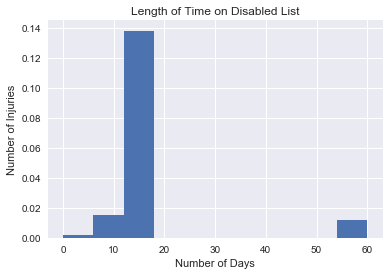

In [345]:
plt.hist(injury_df.DL_length, normed=True)
plt.title('Length of Time on Disabled List')
plt.xlabel('Number of Days')
plt.ylabel('Number of Injuries')

## Which Team Has the Most Severe Injuries?? 
### Plot DL-length by Team
* Most of the teams have mean DL-length between 15 and 20, but the Expos and the Devil Rays had greater variance.

/Users/freedom/anaconda3/lib/python3.6/site-packages/seaborn/categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


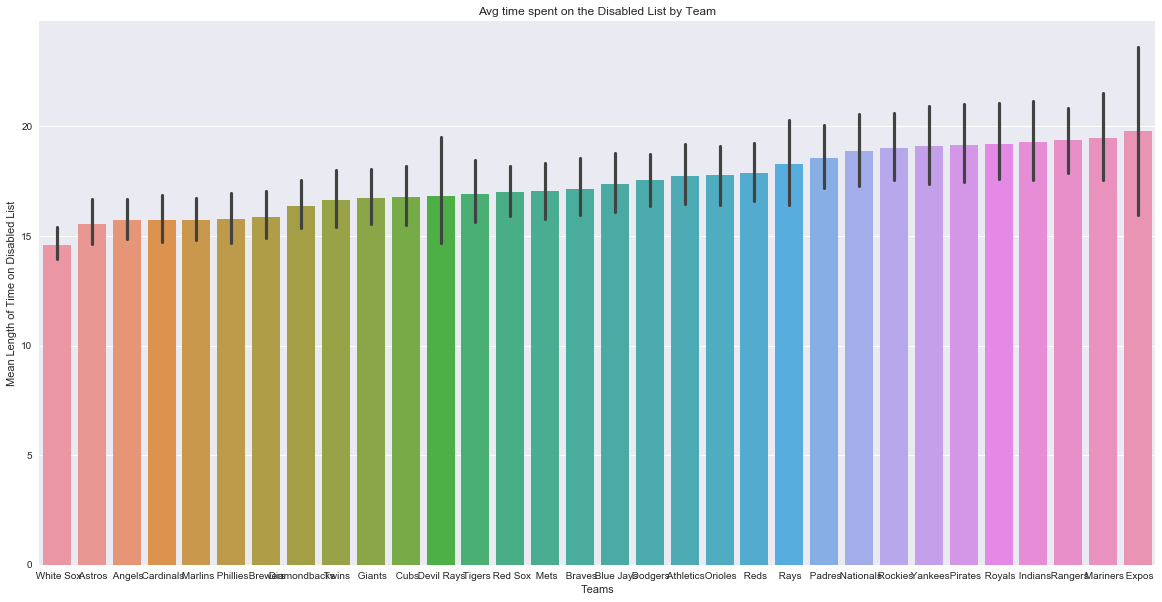

In [349]:
# To sort the barplot by mean length of time on DL
result = injury_df.groupby(["Team"])['DL_length'].aggregate(np.mean).reset_index().sort_values('DL_length')

plt.figure(figsize=(20,10))
sns.barplot(injury_df.Team, injury_df.DL_length, order=result['Team'])
plt.title('Avg time spent on the Disabled List by Team')
plt.xlabel('Teams')
plt.ylabel('Mean Length of Time on Disabled List')

## Plot the Histogram of Team Injuries Count to See if Some Teams Have More Injuries Than Others:
* First, let's make a count of the total number of injuries for each team.
* Then plot a histogram of those counts to see the most common injury counts, as well as the outliers (e.g. onen team has only 50 injuries - two teams have over 350 injuries.

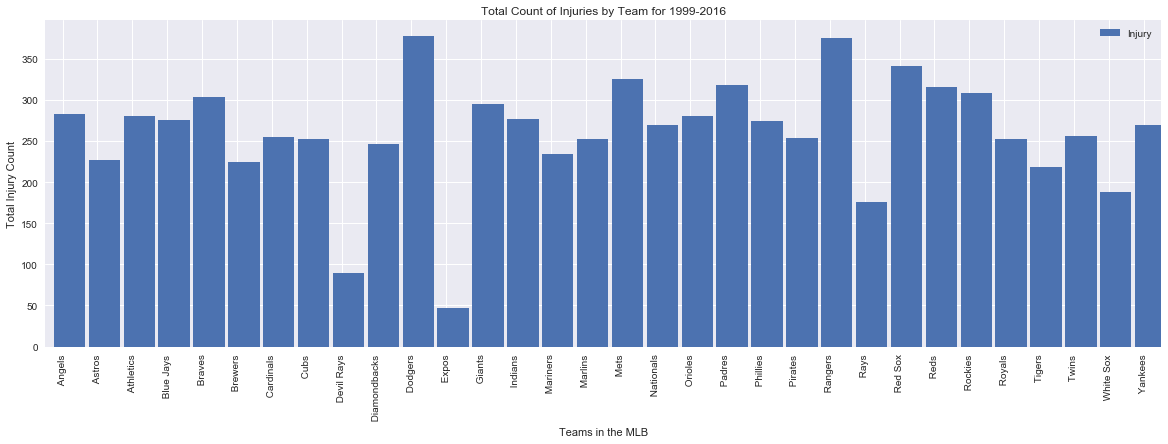

In [397]:
team_count_injury = pd.DataFrame(injury_df.groupby('Team')['Injury'].sum())
ax = team_count_injury.plot(kind='bar',figsize=(20,6))
for container in ax.containers:
              plt.setp(container, width=0.9)
plt.title('Total Count of Injuries by Team for 1999-2016')
plt.xlabel('Teams in the MLB')
plt.ylabel('Total Injury Count')


## Merging the Injuries into the Game Logs
* It turns out that many of the disbled list dates are for the first week of the season, which means that 

In [258]:
injury_df.Date.value_counts()

20150405    66
20160403    55
20110330    52
20130331    51
20120404    46
20060331    40
20010331    39
20160402    38
20140330    37
20140329    33
20050402    33
20080330    32
20070401    30
20020330    27
20100403    27
20070331    25
20100404    23
20150404    23
20080329    22
20040403    21
20090405    21
20030328    16
20120403    16
20030329    16
20090404    16
20070330    15
20070328    14
20160802    13
20110329    13
20100331    12
            ..
20060722     1
20140807     1
20050201     1
20150520     1
20120313     1
20060910     1
20040424     1
20040416     1
20040412     1
20080910     1
20080914     1
20080918     1
20050623     1
20050619     1
20050603     1
20100719     1
20060726     1
20140707     1
20120221     1
20120722     1
20050221     1
20150922     1
20040324     1
20160826     1
20150910     1
20150906     1
20070727     1
20060508     1
20060516     1
20000712     1
Name: Date, Length: 2540, dtype: int64

## The big problem in reviewing the counts of injuries by date is that a lot of the DL placements were on the first few days before the season started. I'm going to remove those from the data because they aren't connected to a specific game.

In [321]:
season_openers = [20000327,20000328,20000329, 20000330,
                  20010331,20010401, 20010402,
                  20020329,20020330, 20020331,20020401,
                  20030328,20030329, 20030330,20030331,
                  20040328,20040329, 20040330,20040331,
                  20050401,20050402, 20050403,20050404, 
                  20060331,20060401, 20060402,20060403,
                  20070330,20070331, 20070401,20070402,
                  20080323,20080324, 20080325,20080326,
                  20090403,20090404, 20090405,20090406,
                  20100402,20100403, 20100404,20100405,
                  20110329,20110330, 20110331,20110401,
                  20120326,20120327, 20120328, 20120329,
                  20130329,20130330, 20130331,20130401,
                  20140320,20140321, 20140322,20140323,
                  20150403,20150404, 20150405,20150406,
                  20160401,20160402, 20160403, 20160404]

In [338]:
print(injury_df.shape)
for start_date in season_openers:
    injury_df.drop(injury_df[injury_df['Date'] == start_date].index, inplace=True)
# Check how many rows remain after we remove the season opener data when most of the DLs go in
print(injury_df.shape)

(7587, 9)
(6794, 9)


In [349]:
# I think I have to merge the DL_length separately for 'v_team' and 'h_team'
merged_df = games_df_v2.merge(injury_df[['Date','team_id','DL_length']], 
                              left_on=['date', 'v_team'], 
                              right_on=['Date','team_id'],
                              how='left')
merged_df = merged_df.merge(injury_df[['Date','team_id','DL_length']], 
                              left_on=['date', 'h_team'], 
                              right_on=['Date','team_id'],
                              how='left')

In [359]:
merged_df['DL_length_x'].fillna(0, inplace=True)
merged_df['DL_length_y'].fillna(0, inplace=True)
merged_df['DL_both_length'] = merged_df['DL_length_x'] + merged_df['DL_length_y']

In [362]:
merged_df['team_id_x'].apply(lambda x: 1 if x.isnull() == False)

,date,num_game,day,v_team,v_league,v_team_game_num,h_team,h_league,h_team_game_num,v_team_score,...,h_dbl_plays,h_trp_plays,attend_imputed,Date_x,team_id_x,DL_length_x,Date_y,team_id_y,DL_length_y,DL_both_length
0,20000329,0,Wed,CHN,NL,1,NYN,NL,1,5,...,4,0,55000.0,NaN,NaN,0.0,NaN,NaN,0.0,0.0
1,20000330,0,Thu,NYN,NL,2,CHN,NL,2,5,...,0,0,55000.0,NaN,NaN,0.0,NaN,NaN,0.0,0.0
2,20000403,0,Mon,COL,NL,1,ATL,NL,1,0,...,1,0,42255.0,NaN,NaN,0.0,NaN,NaN,0.0,0.0
3,20000403,0,Mon,MIL,NL,1,CIN,NL,1,3,...,0,0,55596.0,NaN,NaN,0.0,NaN,NaN,0.0,0.0
4,20000403,0,Mon,SFN,NL,1,FLO,NL,1,4,...,2,0,35101.0,NaN,NaN,0.0,NaN,NaN,0.0,0.0


### I would like to try to create a function that finds the last game a player played before a specific date, target.

In [451]:
injury_df.drop(['Acquired','Injury'], axis=1, inplace=True)
injury_df.drop(injury_df[injury_df['Player_Full_Name'] == ' '].index, inplace=True)

In [467]:
# Remove the bullet point
injury_df['Relinquished'] = injury_df['Relinquished'].apply(lambda x: x.replace('•',''))
# Save the first name as its own column
injury_df['First_Name'] = injury_df['Relinquished'].apply(lambda y: y.split()[0])
# Save the last name as its own column
injury_df['Last_Name'] = injury_df['Relinquished'].apply(lambda y: y.split()[1] if len(y.split())>1 else 'Unknown')